In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/archive/audio_speech_actors_01-24/"
Crema = "/content/drive/MyDrive/AudioWAV/"
Tess = "/content/drive/MyDrive/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/drive/MyDrive/ALL/"

In [ ]:
ravdess_dir_lis = os.listdir(Ravdess)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(Ravdess, directory))
    for audio_file in actor_files:
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{Ravdess}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])

ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/content/drive/MyDrive/archive/audio_speech_ac...,female,happy
1,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral
2,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral
3,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral
4,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral


In [ ]:
crema_dir_list = os.listdir(Crema)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018',
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047',
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072',
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{Crema}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,/content/drive/MyDrive/AudioWAV/1080_IEO_FEA_H...,male,fear
1,/content/drive/MyDrive/AudioWAV/1080_IEO_ANG_H...,male,angry
2,/content/drive/MyDrive/AudioWAV/1080_IEO_DIS_H...,male,disgust
3,/content/drive/MyDrive/AudioWAV/1080_IEO_SAD_H...,male,sad
4,/content/drive/MyDrive/AudioWAV/1080_IEO_HAP_H...,male,happy


In [ ]:
tess_dir_list = os.listdir(Tess)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(Tess, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{Tess}{directory}/{audio_file}")
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])

tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,/content/drive/MyDrive/TESS Toronto emotional ...,female,happy
1,/content/drive/MyDrive/TESS Toronto emotional ...,female,happy
2,/content/drive/MyDrive/TESS Toronto emotional ...,female,happy
3,/content/drive/MyDrive/TESS Toronto emotional ...,female,happy
4,/content/drive/MyDrive/TESS Toronto emotional ...,female,happy


In [ ]:
savee_dir_list = os.listdir(Savee)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{Savee}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])

savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,/content/drive/MyDrive/ALL/DC_a10.wav,male,angry
1,/content/drive/MyDrive/ALL/DC_a02.wav,male,angry
2,/content/drive/MyDrive/ALL/DC_a11.wav,male,angry
3,/content/drive/MyDrive/ALL/DC_a01.wav,male,angry
4,/content/drive/MyDrive/ALL/DC_a06.wav,male,angry


In [ ]:
df = pd.concat([
    ravdess_df,
    crema_df,
    tess_df,
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,/content/drive/MyDrive/archive/audio_speech_ac...,female,happy
1,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral
2,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral
3,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral
4,/content/drive/MyDrive/archive/audio_speech_ac...,female,neutral


In [ ]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

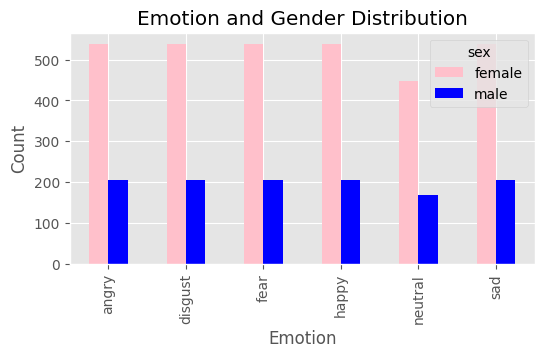

In [ ]:
def plot_distribution(df):
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_distribution(df)

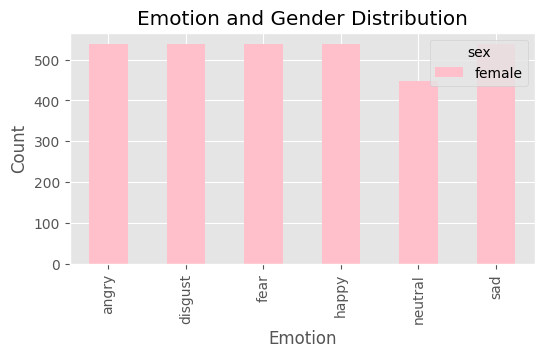

In [ ]:
df = df[df['sex'] == 'female']
plot_distribution(df)

In [ ]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,/content/drive/MyDrive/archive/audio_speech_ac...,happy
1,/content/drive/MyDrive/archive/audio_speech_ac...,neutral
2,/content/drive/MyDrive/archive/audio_speech_ac...,neutral
3,/content/drive/MyDrive/archive/audio_speech_ac...,neutral
4,/content/drive/MyDrive/archive/audio_speech_ac...,neutral


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment, effects

In [17]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)

    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [18]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2,
    'angry'   : 3,
    'fear'    : 4,
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

In [ ]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try:
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /content/drive/MyDrive/archive/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [19]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

LSTM model

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [21]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.15, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [22]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [23]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=70)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val_class))

Epoch 1/100
57/57 [==============================] - 34s 525ms/step - loss: 1.4926 - categorical_accuracy: 0.3527 - val_loss: 1.4086 - val_categorical_accuracy: 0.3289
Epoch 2/100
57/57 [==============================] - 26s 445ms/step - loss: 1.3765 - categorical_accuracy: 0.3967 - val_loss: 1.3533 - val_categorical_accuracy: 0.4222
Epoch 3/100
57/57 [==============================] - 26s 464ms/step - loss: 1.3413 - categorical_accuracy: 0.3923 - val_loss: 1.3162 - val_categorical_accuracy: 0.4667
Epoch 4/100
57/57 [==============================] - 27s 468ms/step - loss: 1.2493 - categorical_accuracy: 0.4780 - val_loss: 1.2552 - val_categorical_accuracy: 0.4889
Epoch 5/100
57/57 [==============================] - 27s 473ms/step - loss: 1.2285 - categorical_accuracy: 0.4923 - val_loss: 1.2500 - val_categorical_accuracy: 0.5067
Epoch 6/100
57/57 [==============================] - 27s 481ms/step - loss: 1.1591 - categorical_accuracy: 0.5214 - val_loss: 1.1986 - val_categorical_accuracy:

In [ ]:
from sklearn.metrics import confusion_matrix

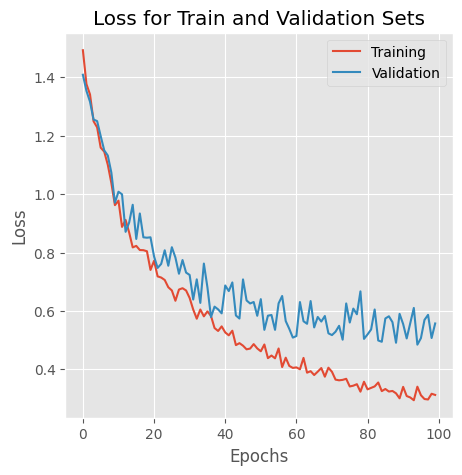

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Loss for Train and Validation Sets')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.show()

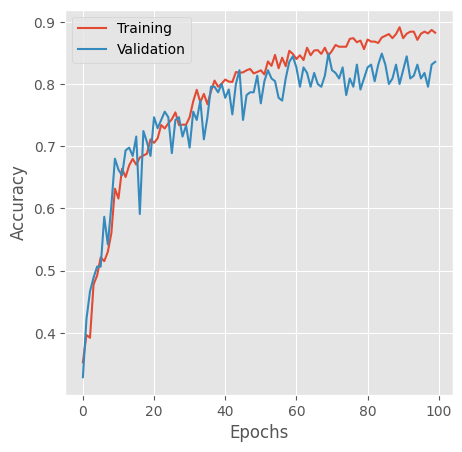

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(model.history['categorical_accuracy'])
plt.plot(model.history['val_categorical_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.show()

8/8 [==============================] - 2s 91ms/step


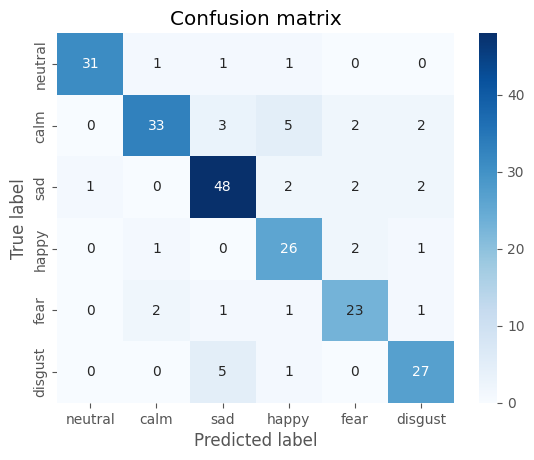

In [ ]:
import seaborn as sns
y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()